## 1. Imports and Datasets

In [1]:
using HTTP, DataFrames, CSV, PrettyTables, Plots;
using PlotlyJS;
using StatsPlots;
using Query, Dates, LsqFit;
using Optim;
using Distributions, Random;

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5707545216295010539\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6262891480932716576\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5707545216295010539\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

### 1.1 Brief Introduction of Datasets
2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE (https://github.com/CSSEGISandData/COVID-19)

The datasets used in this project:
- time_series_covid19_confirmed_global.csv (https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)
- time_series_covid19_deaths_global (https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)
- time_series_covid19_recovered_global.csv (https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)

In [2]:
# Retriving Dataset

urlPrefix = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
global_confirmedFile =  "time_series_covid19_confirmed_global.csv"
global_deathsFile = "time_series_covid19_deaths_global.csv"
global_recoveredFile = "time_series_covid19_recovered_global.csv"

"time_series_covid19_recovered_global.csv"

## 2. Data Preprocessing

#### Functions used to preprocess the data

In [184]:
# function used to make the raw data as a dataframe
makeDF(url) = CSV.read(IOBuffer(String((HTTP.get(url)).body)));

# function used to get Province/State, Country/Region these two column renamed
function cleanNames(df)
    rename!(df,Symbol("Province/State")=>:ProvinceOrState)
    rename!(df,Symbol("Country/Region")=>:CountryOrRegion)
end

function cleanNames2(df)
    rename!(df,Symbol("Province/State")=>:ProvinceOrState)
    rename!(df,Symbol("Country/Region")=>:CountryOrRegion)
end

#This function can be used for country data
#type is :confirmed, :deaths or :recovered
function countryData(countryName,dfType; sumProvinces = true)
    if dfType == :confirmed
        df = global_confirmedDF
    elseif dfType == :deaths
        df = global_deathsDF
    elseif dfType == :recovered
        df = global_recoveredDF
    else
        println("error")
    end
    # group the dataframe by CountryOrRegion
    df = groupby(df,:CountryOrRegion; sort=false, skipmissing=false);
    df = combine(df, names(df)[Not(1:4)] .=> sum);
    CountryData = df[df.CountryOrRegion .== countryName, :];
    if sumProvinces
        CountryData = DataFrames.stack(CountryData, names(CountryData))[2:end,:];
        CountryData[:1] = string.(collect(CountryData[:1]));
        CountryData[:2] = Int.(collect(CountryData[:2]));
        return CountryData
    else 
        return CountryData
    end
end

# function used to change date data type
function cleanDate(df,dfType)
    i = 1;
    dateArray = Date.([]);
    for date in df[:,:1]
        m, d, y = split(date,"/");
        push!(dateArray,Dates.Date(parse(Int64,"20"*(y[1:2])),parse(Int64,m),parse(Int64,d)));
        i += 1;
    end
    df[:1] = dateArray;
    if dfType == :confirmed
        names!(df, [:date, :total_confirmed]);
    elseif dfType == :deaths
        names!(df, [:date, :total_deaths]);
    elseif dfType == :recovered
        names!(df, [:date, :total_recovered]);
    else
        println("error")
    end
    return df
end


function countrylevelData(df)
    countrylevelData = groupby(df,:CountryOrRegion; sort=false, skipmissing=false);
    countrylevelData = combine(countrylevelData, names(countrylevelData)[Not(1:4)] .=> sum);
    numDays = size(countrylevelData)[2]-1
    for i in 1:numDays
        rename!(countrylevelData,names(countrylevelData)[1+i]=>"day$i")
    end
    return countrylevelData
end

countrylevelData (generic function with 1 method)

### 2.1. Data Preprocessing

In [185]:
# load the global confirmed/deaths/recovered cases data 
global_confirmedDF = makeDF(urlPrefix*global_confirmedFile);
global_deathsDF = makeDF(urlPrefix*global_deathsFile);
global_recoveredDF = makeDF(urlPrefix*global_recoveredFile);

# Use the cleanNames() function to get Province/State, Country/Region in each dataframe renamed
cleanNames(global_confirmedDF)
cleanNames(global_deathsDF)
cleanNames(global_recoveredDF)

# Drop missing value: if the value in CountryOrRegion column is missing, we drop this record
global_confirmedDF = dropmissing(global_confirmedDF, :CountryOrRegion);
global_deathsDF = dropmissing(global_deathsDF, :CountryOrRegion);
global_recoveredDF = dropmissing(global_recoveredDF, :CountryOrRegion);


# Get country-level data
global_confirmed_country_level = countrylevelData(global_confirmedDF);
global_deaths_country_level = countrylevelData(global_deathsDF);
global_recovered_country_level = countrylevelData(global_recoveredDF);

## 3. General Analysis of Data



### Total number of confirmed cases, deaths reported and revoveries cases all across the world till today.

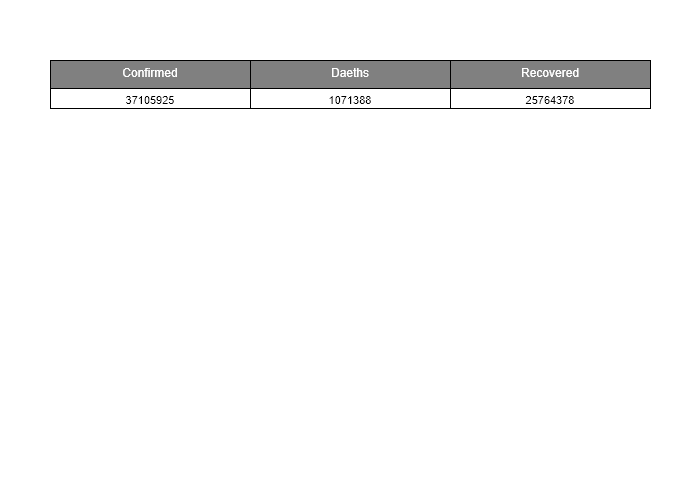

In [186]:
function globalreportCase()
    values = [
       sum(global_confirmed_country_level[:,end]) sum(global_deaths_country_level[:,end]) sum(global_recovered_country_level[:,end])
    ]

    trace = table(
        header=attr(
            values=["Confirmed" "Daeths" "Recovered"],
            align="center", line=attr(width=1, color="black"),
            fill_color="grey", font=attr(family="Arial", size=12, color="white")
        ),
        cells=attr(
            values=values, align="center", line=attr(color="black", width=1),
            font=attr(family="Arial", size=11, color="black")
        )
    )
    PlotlyJS.plot(trace)

end



globalreportCase()

### Global spread of COVID-19 over time

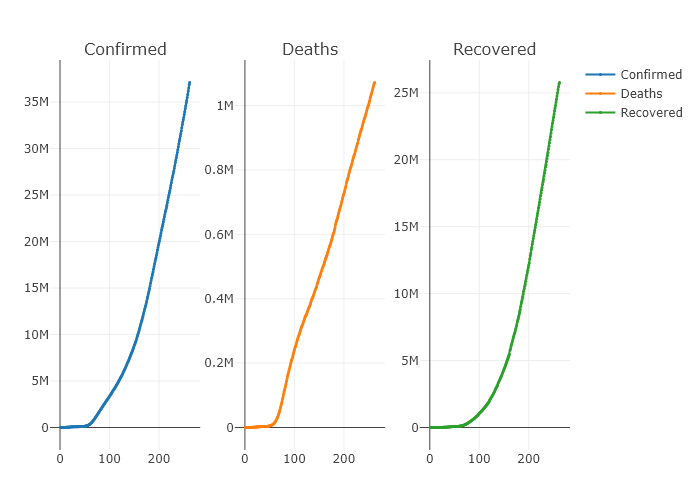

In [187]:
globalDailyConfirmed = combine(global_confirmed_country_level, names(global_confirmed_country_level)[Not(1)] .=> sum);
globalDailyDeaths = combine(global_deaths_country_level, names(global_deaths_country_level)[Not(1)] .=> sum);
globalDailyRecovered = combine(global_recovered_country_level, names(global_recovered_country_level)[Not(1)] .=> sum);

function globalSpread()
    p1 = PlotlyJS.plot(convert(Array{Int},globalDailyConfirmed[:,2:end])',
        Layout(title="Confirmed"),mode="lines+markers",marker_size=3,
        name= "Confirmed")
    p2 = PlotlyJS.plot(convert(Array{Int},globalDailyDeaths[:,2:end])', 
        Layout(title="Deaths"),mode="lines+markers",marker_size=3,
        name = "Deaths")
    p3 = PlotlyJS.plot(convert(Array{Int},globalDailyRecovered[:,2:end])',
        Layout(title="Recovered"),mode="lines+markers",marker_size=3,
        name = "Recovered")
    p = [p1 p2 p3]
    p
end


globalSpread()

###  Top 10 countries (Confirmed Cases, Deaths and Recovered)

- __Top 10 confirmed__

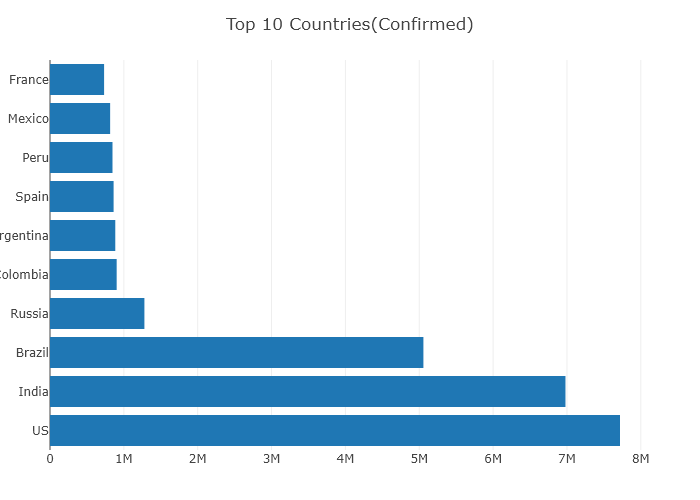

In [188]:
top10_confirmed = sort!(global_confirmed_country_level[:,[1,end]],[:2],rev = true)[1:10, :];

function top10Confirmed()
    data = top10_confirmed;
    p = PlotlyJS.bar(x = convert(Array{Float64},data[1:10,2]), 
                      y = convert(Array{String},data[1:10,1]),
                      orientation=:h);
    
    layout = Layout(;title="Top 10 Countries(Confirmed)")
    PlotlyJS.plot(p, layout)
end
top10Confirmed()

- __Top 10 deaths__

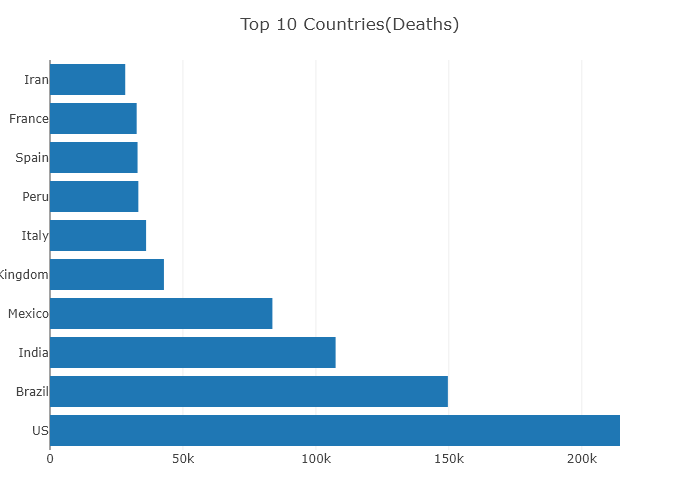

In [189]:
top10_deaths = sort!(global_deaths_country_level[:,[1,end]],[:2],rev = true)[1:10, :];
function top10Deaths()
    data = top10_deaths;
    p = PlotlyJS.bar(x = convert(Array{Float64},data[1:10,2]), 
                      y = convert(Array{String},data[1:10,1]),
                      orientation=:h);
    
    layout = Layout(;title="Top 10 Countries(Deaths)")
    PlotlyJS.plot(p, layout)
end
top10Deaths()

- __Top 10 recovered__

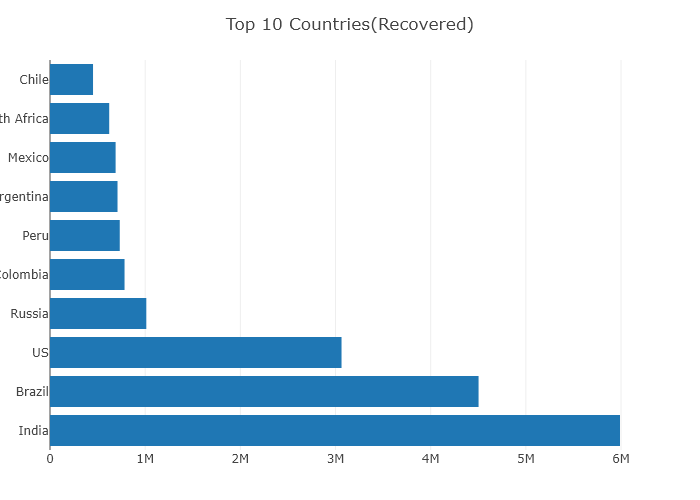

In [190]:
top10_recovered = sort!(global_recovered_country_level[:,[1,end]],[:2],rev = true)[1:10, :];
function top10Recovered()
    data = top10_recovered;
    p = PlotlyJS.bar(x = convert(Array{Float64},data[1:10,2]), 
                      y = convert(Array{String},data[1:10,1]),
                      orientation=:h);
    
    layout = Layout(;title="Top 10 Countries(Recovered)")
    PlotlyJS.plot(p, layout)
end
top10Recovered()

- __Top 10 recovery rate__

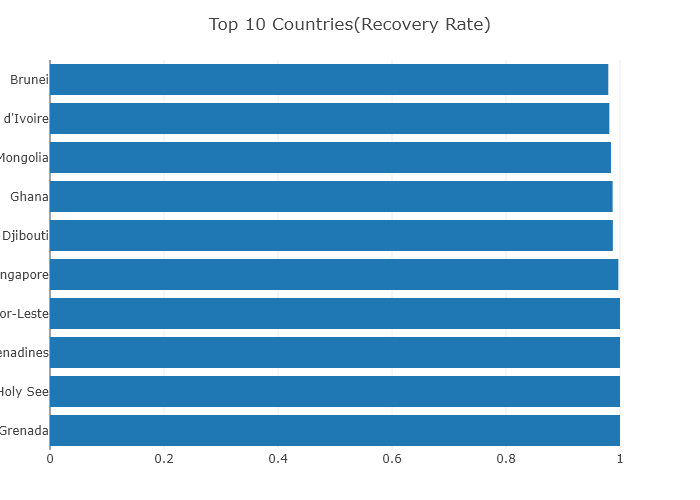

In [191]:
globalTotalRecovered = global_recovered_country_level[:,[1,end]];
globalTotalConfirmed = global_confirmed_country_level[:,[1,end]];
globalTotalDeaths = global_deaths_country_level[:,[1,end]];

globalTotalRecover = leftjoin(globalTotalRecovered, globalTotalConfirmed, on = :CountryOrRegion, makeunique=true);
names(globalTotalRecover)[2:3] = ["totalRecovered", "totalConfirmed"];
globalTotalRecover[:recoveryRate] = globalTotalRecover[:, 2] ./ globalTotalRecover[:, 3];
globalTotalRecover = sort!(globalTotalRecover, :recoveryRate, rev = true);


function top10RecoverRate()
    data = globalTotalRecover;
    p = PlotlyJS.bar(x = convert(Array{Float64},data[1:10,4]), 
                      y = convert(Array{String},data[1:10,1]),
                      orientation=:h);
    
    layout = Layout(;title="Top 10 Countries(Recovery Rate)");
    PlotlyJS.plot(p, layout)
end
top10RecoverRate()

- __Top 10 fatality rate__

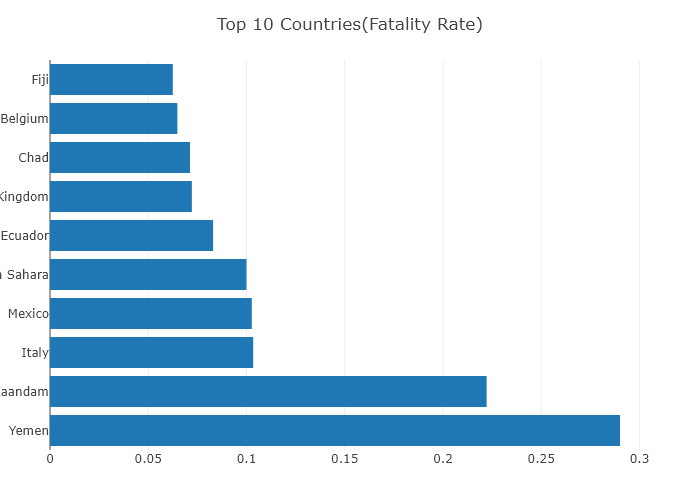

In [192]:
globalTotalDeaths = leftjoin(globalTotalDeaths, globalTotalConfirmed, on = :CountryOrRegion, makeunique=true);
names(globalTotalDeaths)[2:3] = ["totalDeaths", "totalConfirmed"];
globalTotalDeaths[:fatalityRate] = globalTotalDeaths[:, 2] ./ globalTotalDeaths[:, 3];
globalTotalDeaths = sort!(globalTotalDeaths, :fatalityRate, rev = true);

function top10FatalityRate()
    data = globalTotalDeaths;
    p = PlotlyJS.bar(x = convert(Array{Float64},data[1:10,4]), 
                     y = convert(Array{String},data[1:10,1]),
                     orientation=:h);
    
    layout = Layout(;title="Top 10 Countries(Fatality Rate)");
    PlotlyJS.plot(p, layout)
end
top10FatalityRate()

###  Visualization on Map

In [193]:
using WebIO
WebIO.install_jupyter_nbextension()

┌ Info: Installing Jupyter WebIO extension...
│   cmd = `'C:\Python37\Scripts\jupyter.exe' nbextension install --user 'C:\Users\Xuerong Wang\.julia\packages\WebIO\Fy9h1\deps\bundles\webio-jupyter-notebook.js'`
└ @ WebIO C:\Users\Xuerong Wang\.julia\packages\WebIO\Fy9h1\deps\jupyter.jl:237
Up to date: C:\Users\Xuerong Wang\AppData\Roaming\jupyter\nbextensions\webio-jupyter-notebook.js

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable <the entry point> --user
    
┌ Info: Enabling Jupyter WebIO extension...
│   cmd = `'C:\Python37\Scripts\jupyter.exe' nbextension enable --user webio-jupyter-notebook`
└ @ WebIO C:\Users\Xuerong Wang\.julia\packages\WebIO\Fy9h1\deps\jupyter.jl:241
Enabling notebook extension webio-jupyter-notebook...
      - Validating: ok


#### Global Confirmed Bubble Map

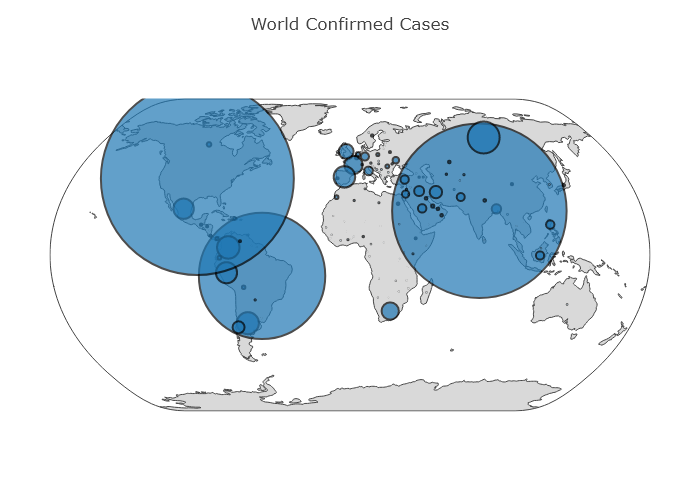

In [194]:
countryCode = names!(DataFrame(CSV.read("location.csv")[:,2:3]), [:CountryOrRegion, :Locations]);
gc = global_confirmed_country_level[:,[1,end]];
gc.CountryOrRegion = replace.(gc.CountryOrRegion, Ref("US" => "United States"));
gc = leftjoin(gc, countryCode, on = :CountryOrRegion);
gc = names!(gc, [:CountryOrRegion, :total_confirmed, :Locations]);


confirmed_trace = scattergeo(;locations=gc["Locations"],
                               hoverinfo="text",
                               text=[string(x[:CountryOrRegion], " confirmed: ", x[:2]) for x in eachrow(gc)],
                               marker_size=gc[:total_confirmed]/40000,
                                                       marker_line_color="black", marker_line_width=2);

geo = attr(scope="natural earth",
               projection_type="natural earth",
               showland=true,
               landcolor="rgb(217, 217, 217)",
               subunitwidth=1,
               countrywidth=1,
               subunitcolor="rgb(255,255,255)",
               countrycolor="rgb(255,255,255)");

confirmed_layout = Layout(;title="World Confirmed Cases", showlegend=false, geo=geo);

PlotlyJS.plot(confirmed_trace, confirmed_layout)

#### Global Deaths Bubble Map

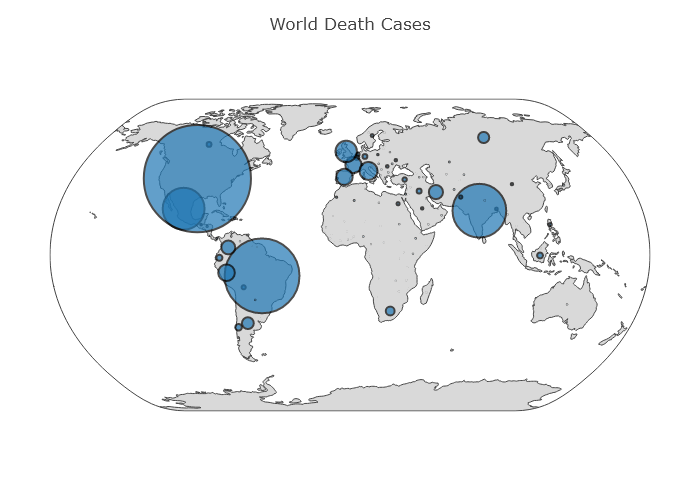

In [200]:
gd = global_deaths_country_level[:,[1,end]];
gd.CountryOrRegion = replace.(gc.CountryOrRegion, Ref("US" => "United States"));
gd = leftjoin(gd, countryCode, on = :CountryOrRegion);
gd = names!(gd, [:CountryOrRegion, :total_deaths, :Locations]);


death_trace = scattergeo(;locations=gc["Locations"],
                               hoverinfo="text",
                               text=[string(x[:CountryOrRegion], " death: ", x[:total_deaths]) for x in eachrow(gd)],
                               marker_size=gd[:total_deaths]/2000,
                                                       marker_line_color="black", marker_line_width=2);

geo = attr(scope="natural earth",
               projection_type="natural earth",
               showland=true,
               landcolor="rgb(217, 217, 217)",
               subunitwidth=1,
               countrywidth=1,
               subunitcolor="rgb(255,255,255)",
               countrycolor="rgb(255,255,255)");

death_layout = Layout(;title="World Death Cases", showlegend=false, geo=geo);

PlotlyJS.plot(death_trace, death_layout)

#### Global Recovered Bubble Map

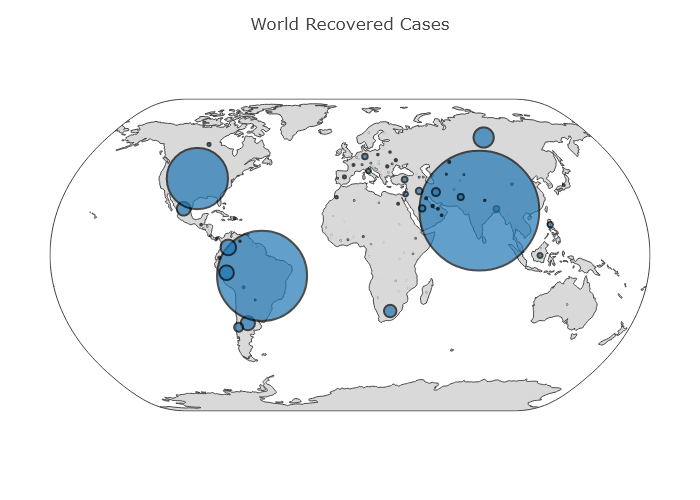

In [196]:
gr =  global_recovered_country_level[:,[1,end]];
gr.CountryOrRegion = replace.(gc.CountryOrRegion, Ref("US" => "United States"));
gr = leftjoin(gr, countryCode, on = :CountryOrRegion);
gr = names!(gr, [:CountryOrRegion, :total_recovered, :Locations]);


recovered_trace = scattergeo(;locations=gr["Locations"],
                               hoverinfo="text",
                               text=[string(x[:CountryOrRegion], " recovered: ", x[:total_recovered]) for x in eachrow(gr)],
                               marker_size=gr[:total_recovered]/50000,
                                                       marker_line_color="black", marker_line_width=2);

geo = attr(scope="natural earth",
               projection_type="natural earth",
               showland=true,
               landcolor="rgb(217, 217, 217)",
               subunitwidth=1,
               countrywidth=1,
               subunitcolor="rgb(255,255,255)",
               countrycolor="rgb(255,255,255)");

recovered_layout = Layout(;title="World Recovered Cases", showlegend=false, geo=geo);

PlotlyJS.plot(recovered_trace, recovered_layout)

### Real COVID-19 Data in USA, China and Australia

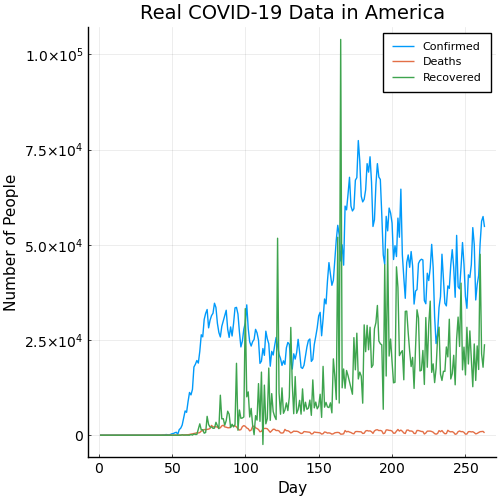

In [291]:
usa_cumulative_deaths[:timeRange] = Dates.value.(usa_cumulative_deaths[:1] - Dates.Date(2020,1,22))
usa_cumulative_deaths[!, :daily_deaths] .= 0;
usa_cumulative_deaths[:daily_deaths][2:end] = diff(usa_cumulative_deaths.total_deaths);

usa_cumulative_recovered = cleanDate(countryData("US",:recovered; sumProvinces = true),:recovered);
usa_cumulative_recovered[:timeRange] = Dates.value.(usa_cumulative_recovered[:1] - Dates.Date(2020,1,22))
usa_cumulative_recovered[!, :daily_recovered] .= 0;
usa_cumulative_recovered[:daily_recovered][2:end] = diff(usa_cumulative_recovered.total_recovered);


# Plot the real data in Australia
Plots.plot(x =[i for i in 1:size(usa_cumulative_confirmed,1)],usa_cumulative_confirmed.daily_confirmed, label = "Confirmed", legend = true)
Plots.plot!(x =[i for i in 1:size(usa_cumulative_deaths,1)],usa_cumulative_deaths.daily_deaths, label = "Deaths")
Plots.plot!(x =[i for i in 1:size(usa_cumulative_recovered,1)],usa_cumulative_recovered.daily_recovered, label = "Recovered",
            title = "Real COVID-19 Data in America",
            xlabel = "Day", ylabel = "Number of People",
            legend = :topright)


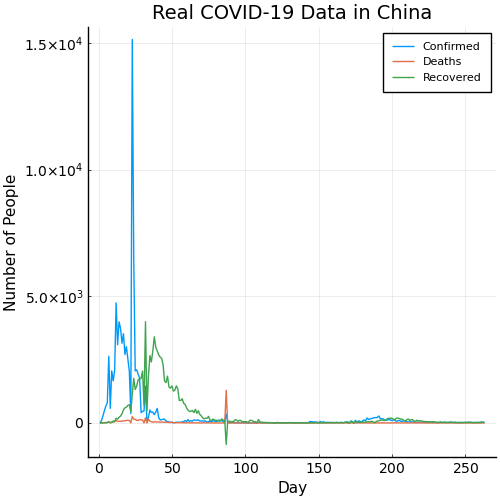

In [292]:
china_cumulative_deaths[:timeRange] = Dates.value.(china_cumulative_deaths[:1] - Dates.Date(2020,1,22))
china_cumulative_deaths[!, :daily_deaths] .= 0;
china_cumulative_deaths[:daily_deaths][2:end] = diff(china_cumulative_deaths.total_deaths);

china_cumulative_recovered = cleanDate(countryData("China",:recovered; sumProvinces = true),:recovered);
china_cumulative_recovered[:timeRange] = Dates.value.(china_cumulative_recovered[:1] - Dates.Date(2020,1,22))
china_cumulative_recovered[!, :daily_recovered] .= 0;
china_cumulative_recovered[:daily_recovered][2:end] = diff(china_cumulative_recovered.total_recovered);


# Plot the real data in Australia
Plots.plot(x =[i for i in 1:size(china_cumulative_confirmed,1)],china_cumulative_confirmed.daily_confirmed, label = "Confirmed", legend = true)
Plots.plot!(x =[i for i in 1:size(china_cumulative_deaths,1)],china_cumulative_deaths.daily_deaths, label = "Deaths")
Plots.plot!(x =[i for i in 1:size(china_cumulative_recovered,1)],china_cumulative_recovered.daily_recovered, label = "Recovered",
            title = "Real COVID-19 Data in China",
            xlabel = "Day", ylabel = "Number of People",
            legend = :topright)

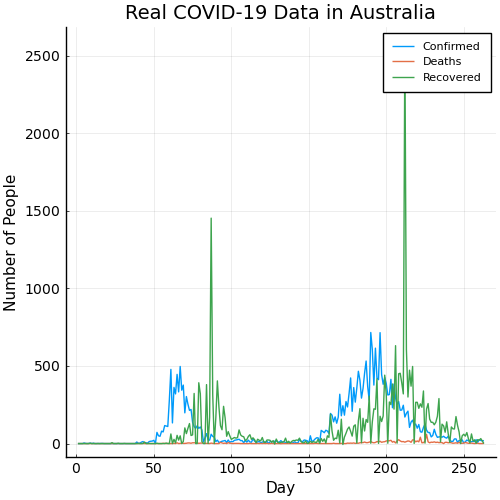

In [293]:
australia_cumulative_deaths[:timeRange] = Dates.value.(australia_cumulative_deaths[:1] - Dates.Date(2020,1,26))
australia_cumulative_deaths[!, :daily_deaths] .= 0;
australia_cumulative_deaths[:daily_deaths][2:end] = diff(australia_cumulative_deaths.total_deaths);

australia_cumulative_recovered = cleanDate(countryData("Australia",:recovered; sumProvinces = true),:recovered);
australia_cumulative_recovered[:timeRange] = Dates.value.(australia_cumulative_recovered[:1] - Dates.Date(2020,1,26))
australia_cumulative_recovered[!, :daily_recovered] .= 0;
australia_cumulative_recovered[:daily_recovered][2:end] = diff(australia_cumulative_recovered.total_recovered);


# Plot the real data in Australia
Plots.plot(x =[i for i in 1:size(australia_cumulative_confirmed,1)],australia_cumulative_confirmed.daily_confirmed, label = "Confirmed", legend = true)
Plots.plot!(x =[i for i in 1:size(australia_cumulative_deaths,1)],australia_cumulative_deaths.daily_deaths, label = "Deaths")
Plots.plot!(x =[i for i in 1:size(australia_cumulative_recovered,1)],australia_cumulative_recovered.daily_recovered, label = "Recovered",
            title = "Real COVID-19 Data in Australia",
            xlabel = "Day", ylabel = "Number of People",
            legend = :topright)

## 3. The modified SEIR model

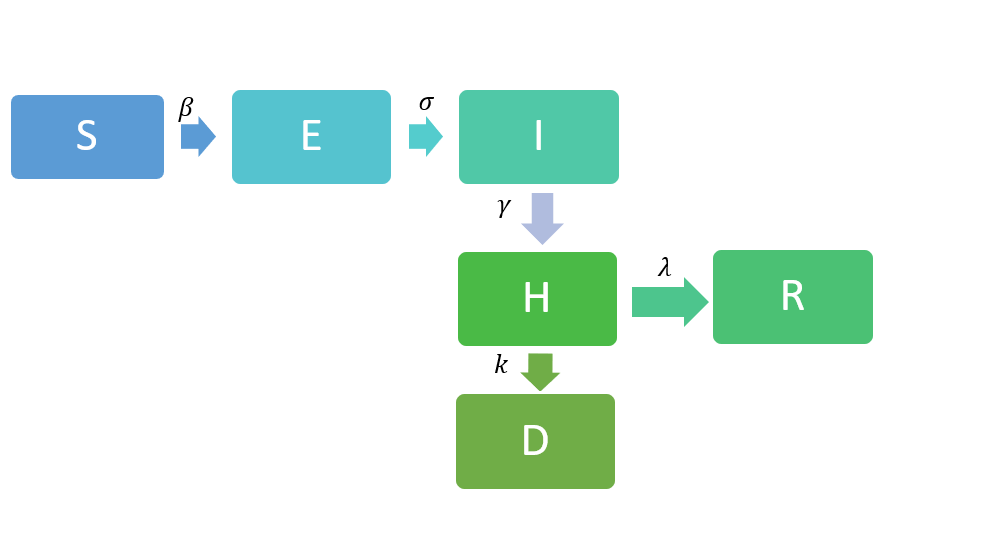
In this modified SEIR model, we have __6__ compartments: __S(susceptible)__, __E(exposed)__, __I(infectious)__, __R(recovered)__, __H(hospitalized)__, __D(dead)__.<br>
Our model is given by:<br>

\begin{equation}
S(t+1) = S(t) - \frac{\beta_{1} \times r \times I(t) \times S(t)}{M(t)} - \frac{\beta_{2} \times r \times E(t) \times S(t)}{M(t)}\\
E(t+1) = E(t) + \frac{\beta_{1} \times r \times I(t) \times S(t)}{M(t)} + \frac{\beta_{2} \times r \times E(t) \times S(t)}{M(t)} - \sigma \times E(t)\\
I(t+1) = I(t) + \sigma \times E(t) - \gamma \times I(t)\\
H(t+1) = H(t) + \gamma \times I(t) -\lambda \times H(t) - k \times H(t)\\
R(t+1) = R(t) + \lambda \times H(t)\\
D(t+1) = D(t) + k \times H(t)
\end{equation}

$S(t)$: The number of susceptible people in a country or region.<br>
$\beta_{1}$: The rate of transmission for the susceptible to infected.<br>
$\beta_{2}$: The rate of transmission for the susceptible to exposed.<br>
$r$: The contact ratey, related to control policies.<br>
$M(t)$: The total population in a country or region.<br>
$E(t)$: The number of exposed people in a country or region.<br>
$\sigma$: The incubation rate.<br>
$I(t)$: The number of infected people in a country or region.<br>
$\gamma$: The hospitalization rate.<br>
$H(t)$: The number of hospitalized people in a country or region.<br>
$\lambda$: The recovery rate.<br>
$R(t)$: The number of recovered people in a country or region.<br>
$k$: The mortality rate by covid-19.<br>
$D(t)$: The number of dead people by the virus in a country or region.<br>

### 3.1. Model Parameters Estimation  

In order to apply the modified SEIR model above, we need to estimate the parameters $\beta$, $\sigma$, $\gamma$, $\lambda$ and $k$, where $\beta$ is the product of the people exposed to each day by infected people ($n$) and the probability of transmission ($b$) when exposed (i.e.,$\beta= nb$) and $\sigma$ is the incubation rate which is the rate of latent
individuals becoming symptomatic (average duration of incubation is $\frac{1}{\sigma}$). According to the information from WHO, the incubation period for COVID-19 is on average 5-6 days. Therefore, I decided to choose the midpoint of 5.5 days. $\gamma$ is the average rate of hospitalization which is about 0.22. $\lambda$ is the average rate of recovery in hospitalized(infected) populations, and $k$ is the average mortality rate caused by covid-19. Using epidemic data from some selected countries, I modeled the skewed SEIR model to determine the probability of transmission (b) which was used to derive $\beta$, $\lambda$ and $k$.<br>

With $I(t=0)=1$, which is available early in the outbreak, N≈S and therefore approximates$\frac{dI}{dt} = \beta \frac{IS}{M} - \lambda I \approx (\beta - \lambda)I$. It is easy to know that the general solution of the differential equation is $I(t) = Ce^{(\beta-\lambda)t}$. Since $I(t=0) = 1$, we can get $C = 1 \Longrightarrow I(t) = e^{(\beta-\lambda)t}$. 

Now, our objective function is $$\mathbf{min}\sum_{t\in T}^{} (e^{(\beta-\lambda)t} - \hat{I}(t))^{2}$$, where $\hat{I}(t)$ is the actual number of confirmed cases.

###  $\beta_1$, $\beta_2$ and $\lambda$ in U.S. 

Since the first case of covid-19 was confirmed on the __2020-01-22__ in the US, I added a column named timeRange which used to store the difference between the date of current row and __2020-01-22__.

In [199]:
usa_cumulative_confirmed = cleanDate(countryData("US",:confirmed; sumProvinces = true),:confirmed);
usa_cumulative_confirmed[:timeRange] = Dates.value.(usa_cumulative_confirmed[:1] - Dates.Date(2020,1,22));
usa_cumulative_confirmed[!, :daily_confirmed] .= 0;
usa_cumulative_confirmed[:daily_confirmed][2:end] = diff(usa_cumulative_confirmed.total_confirmed);
usa_cumulative_confirmed

263×4 DataFrame
│ Row │ date       │ total_confirmed │ timeRange │ daily_confirmed │
│     │ Date       │ Int64           │ Int64     │ Int64           │
├─────┼────────────┼─────────────────┼───────────┼─────────────────┤
│ 1   │ 2020-01-22 │ 1               │ 0         │ 0               │
│ 2   │ 2020-01-23 │ 1               │ 1         │ 0               │
│ 3   │ 2020-01-24 │ 2               │ 2         │ 1               │
│ 4   │ 2020-01-25 │ 2               │ 3         │ 0               │
│ 5   │ 2020-01-26 │ 5               │ 4         │ 3               │
│ 6   │ 2020-01-27 │ 5               │ 5         │ 0               │
│ 7   │ 2020-01-28 │ 5               │ 6         │ 0               │
│ 8   │ 2020-01-29 │ 6               │ 7         │ 1               │
│ 9   │ 2020-01-30 │ 6               │ 8         │ 0               │
│ 10  │ 2020-01-31 │ 8               │ 9         │ 2               │
⋮
│ 253 │ 2020-09-30 │ 7233042         │ 252       │ 41405           │
│ 254 │ 2020-10-01 │ 7277791         │ 253       │ 44749           │
│ 255 │ 2020-10-02 │ 7332297         │ 254       │ 54506           │
│ 256 │ 2020-10-03 │ 7382341         │ 255       │ 50044           │
│ 257 │ 2020-10-04 │ 7417845         │ 256       │ 35504           │
│ 258 │ 2020-10-05 │ 7457402         │ 257       │ 39557           │
│ 259 │ 2020-10-06 │ 7499341         │ 258       │ 41939           │
│ 260 │ 2020-10-07 │ 7549682         │ 259       │ 50341           │
│ 261 │ 2020-10-08 │ 7605873         │ 260       │ 56191           │
│ 262 │ 2020-10-09 │ 7663293         │ 261       │ 57420           │
│ 263 │ 2020-10-10 │ 7717932         │ 262       │ 54639           │

The table above inclueds the data of cumulative confirmed cases in the US from __2020-01-22__ till today. It is obvious that the data beore __2020-02-29__ may be not accurate, so I decided to select the data from __2020-02-29 to 2020-03-09__ to identify the probability of infection $b$.<br>

As the US epidemic prevention and control measures are not strict during this period, we can assume that the contact rate is around __10__.

In [202]:
# select the data from 2020-02-29 to 2020-03-09 
ten_day_confirmed_usa = usa_cumulative_confirmed[(usa_cumulative_confirmed.date .<= Dates.Date(2020,3,9)) .& 
    (usa_cumulative_confirmed.date .>= Dates.Date(2020,2,29)),:];

# contact rate of U.S. between 2020-02-29 and 2020-03-09
nContact = 10;

# the cost function
f(x) = sum((exp.((x[1]*nContact - x[2])*ten_day_confirmed_usa.timeRange) - ten_day_confirmed_usa.total_confirmed).^2)/(size(ten_day_confirmed_usa.timeRange)[1])

# starting point
x0 = [0.04, 0.1]

# optimize the cost function
results = optimize(f, x0, NelderMead());

# print the optimization results
println("The probability of transmission of U.S.: ", Optim.minimizer(results)[1])
println("The recovery rate of U.S.: ", Optim.minimizer(results)[2])

The probability of transmission of U.S.: 0.027559709345011184
The recovery rate of U.S.: 0.14585997990482513


I assume that a symptomatic, infectious $I$ will be quarantined, therefore the people exposed to each day by $n_1 = 3$ infected people.<br>
I assume that an asymptomatic, lantent $E$ will have normal contact, therefore the people exposed to each day by $n_1 = 15$ lantent people.
Therefore, $$\beta_{us_{1}} = n_1 \beta_{us} = 3 \times 0.02753 = 0.08259$$ $$\beta_{us_{2}} = n_2 \beta_{us} = 15 \times 0.02753 = 0.41295$$
$$\lambda_{us} = 0.14565$$

###  $\beta_1$, $\beta_2$ and $\lambda$ in China 

Since the first case of covid-19 was confirmed on the __2010-12-08__ in China, I added a column named timeRange which used to store the difference between the date of current row and __2010-12-08__.

In [270]:
# get the chinese cumulative confirmed cases from 1/22/20 - today
china_cumulative_confirmed = cleanDate(countryData("China",:confirmed; sumProvinces = true),:confirmed);
china_cumulative_confirmed[:timeRange] = Dates.value.(china_cumulative_confirmed[:1] - Dates.Date(2019,12,8));
china_cumulative_confirmed[!, :daily_confirmed] .= 0;
china_cumulative_confirmed[:daily_confirmed][2:end] = diff(china_cumulative_confirmed.total_confirmed);
china_cumulative_confirmed

263×4 DataFrame
│ Row │ date       │ total_confirmed │ timeRange │ daily_confirmed │
│     │ Date       │ Int64           │ Int64     │ Int64           │
├─────┼────────────┼─────────────────┼───────────┼─────────────────┤
│ 1   │ 2020-01-22 │ 548             │ 45        │ 0               │
│ 2   │ 2020-01-23 │ 643             │ 46        │ 95              │
│ 3   │ 2020-01-24 │ 920             │ 47        │ 277             │
│ 4   │ 2020-01-25 │ 1406            │ 48        │ 486             │
│ 5   │ 2020-01-26 │ 2075            │ 49        │ 669             │
│ 6   │ 2020-01-27 │ 2877            │ 50        │ 802             │
│ 7   │ 2020-01-28 │ 5509            │ 51        │ 2632            │
│ 8   │ 2020-01-29 │ 6087            │ 52        │ 578             │
│ 9   │ 2020-01-30 │ 8141            │ 53        │ 2054            │
│ 10  │ 2020-01-31 │ 9802            │ 54        │ 1661            │
⋮
│ 253 │ 2020-09-30 │ 90545           │ 297       │ 17              │
│ 254 │ 2020-10-01 │ 90567           │ 298       │ 22              │
│ 255 │ 2020-10-02 │ 90584           │ 299       │ 17              │
│ 256 │ 2020-10-03 │ 90604           │ 300       │ 20              │
│ 257 │ 2020-10-04 │ 90629           │ 301       │ 25              │
│ 258 │ 2020-10-05 │ 90652           │ 302       │ 23              │
│ 259 │ 2020-10-06 │ 90667           │ 303       │ 15              │
│ 260 │ 2020-10-07 │ 90687           │ 304       │ 20              │
│ 261 │ 2020-10-08 │ 90728           │ 305       │ 41              │
│ 262 │ 2020-10-09 │ 90751           │ 306       │ 23              │
│ 263 │ 2020-10-10 │ 90778           │ 307       │ 27              │

The table above inclueds the data of cumulative confirmed cases in China from __2020-01-22__ till today. I decided to select the data from __2020-01-22 to 2020-01-31__ to identify the probability of infection $b$.<br>

As the epidemic prevention and control measures in China are strict during this period, we can assume that the contact rate is around __3__.

In [205]:
# select the data from 2020-01-22 to 2020-01-31 
ten_day_confirmed_china = china_cumulative_confirmed[(china_cumulative_confirmed.date .<= Dates.Date(2020,1,31)) .& 
    (china_cumulative_confirmed.date .>= Dates.Date(2020,1,22)),:];

# contact rate of China between 2020-01-22 and 2020-01-31
nContact = 5;

# the cost function
f(y) = sum((exp.((y[1]*nContact - y[2])*ten_day_confirmed_china.timeRange) - ten_day_confirmed_china.total_confirmed).^2)/(size(ten_day_confirmed_china.timeRange)[1])

# starting point
y0 = [0.04, 0.1]

# optimize the cost function
results = optimize(f, y0, NelderMead());

# print the optimization results
println("The probability of transmission of China: ", Optim.minimizer(results)[1])
println("The recovery rate of China: ", Optim.minimizer(results)[2])

The probability of transmission of China: 0.05266938493049029
The recovery rate of China: 0.09624509072236229


I assume that a symptomatic, infectious $I$ will be quarantined, therefore the people exposed to each day by $n_1 = 3$ infected people.<br>
I assume that an asymptomatic, lantent $E$ will have normal contact, therefore the people exposed to each day by $n_1 = 15$ lantent people.
Therefore, $$\beta_{cn_{1}} = n_1 \beta_{cn} = 3 \times 0.05267 = 0.15801$$ $$\beta_{cn_{2}} = n_2 \beta_{cn} = 15 \times 0.05267 = 0.7901$$ 
$$\lambda_{cn} = 0.09625$$

###  $\beta_1$, $\beta_2$ and $\lambda$ in Australia 

Since the first case of covid-19 was confirmed on the __2010-1-26__ in Australia, I added a column named timeRange which used to store the difference between the date of current row and __2010-1-26__.

In [272]:
# get australian cumulative confirmed cases from 1/22/20 - today
australia_cumulative_confirmed = cleanDate(countryData("Australia",:confirmed; sumProvinces = true),:confirmed);
australia_cumulative_confirmed[:timeRange] = Dates.value.(australia_cumulative_confirmed[:1] - Dates.Date(2020,1,26))
australia_cumulative_confirmed[!, :daily_confirmed] .= 0;
australia_cumulative_confirmed[:daily_confirmed][2:end] = diff(australia_cumulative_confirmed.total_confirmed);
australia_cumulative_confirmed

263×4 DataFrame
│ Row │ date       │ total_confirmed │ timeRange │ daily_confirmed │
│     │ Date       │ Int64           │ Int64     │ Int64           │
├─────┼────────────┼─────────────────┼───────────┼─────────────────┤
│ 1   │ 2020-01-22 │ 0               │ -4        │ 0               │
│ 2   │ 2020-01-23 │ 0               │ -3        │ 0               │
│ 3   │ 2020-01-24 │ 0               │ -2        │ 0               │
│ 4   │ 2020-01-25 │ 0               │ -1        │ 0               │
│ 5   │ 2020-01-26 │ 4               │ 0         │ 4               │
│ 6   │ 2020-01-27 │ 5               │ 1         │ 1               │
│ 7   │ 2020-01-28 │ 5               │ 2         │ 0               │
│ 8   │ 2020-01-29 │ 6               │ 3         │ 1               │
│ 9   │ 2020-01-30 │ 9               │ 4         │ 3               │
│ 10  │ 2020-01-31 │ 9               │ 5         │ 0               │
⋮
│ 253 │ 2020-09-30 │ 27096           │ 248       │ 18              │
│ 254 │ 2020-10-01 │ 27109           │ 249       │ 13              │
│ 255 │ 2020-10-02 │ 27121           │ 250       │ 12              │
│ 256 │ 2020-10-03 │ 27135           │ 251       │ 14              │
│ 257 │ 2020-10-04 │ 27148           │ 252       │ 13              │
│ 258 │ 2020-10-05 │ 27173           │ 253       │ 25              │
│ 259 │ 2020-10-06 │ 27181           │ 254       │ 8               │
│ 260 │ 2020-10-07 │ 27206           │ 255       │ 25              │
│ 261 │ 2020-10-08 │ 27226           │ 256       │ 20              │
│ 262 │ 2020-10-09 │ 27244           │ 257       │ 18              │
│ 263 │ 2020-10-10 │ 27263           │ 258       │ 19              │

The table above inclueds the data of cumulative confirmed cases in Australia from __2020-01-22__ till today. It is obvious that the data beore 2020-03-03 may be not accurate, so I decided to select the data from __2020-03-03 to 2020-03-12__ to identify the probability of infection $b$.<br>

As the Australia border has been closed on __2020-03-20__, and epidemic control measure like social distancing are not too strict, we can assume that the contact rate is around 10 during these period.

In [207]:
# select the data from 2020-03-03 to 2020-03-12
ten_day_confirmed_australia = australia_cumulative_confirmed[(australia_cumulative_confirmed.date .<= Dates.Date(2020,3,12)) .& 
    (australia_cumulative_confirmed.date .>= Dates.Date(2020,3,3)),:];

# contact rate of Australia between 2020-03-03 and 2020-03-12
nContact = 10;

# the cost function
f(z) = sum((exp.((z[1]*nContact - z[2])*ten_day_confirmed_australia.timeRange) - ten_day_confirmed_australia.total_confirmed).^2)/(size(ten_day_confirmed_australia.timeRange)[1])

# starting point
z0 = [0.04, 0.1]

# optimize the cost function
results = optimize(f, z0, NelderMead());

# print the optimization results
println("The probability of transmission of Australia: ", Optim.minimizer(results)[1])
println("The recovery rate of Australia: ", Optim.minimizer(results)[2])

The probability of transmission of Australia: 0.020395941287722034
The recovery rate of Australia: 0.09888480580169849


I assume that a symptomatic, infectious $I$ will be quarantined, therefore the people exposed to each day by $n_1 = 3$ infected people.<br>
I assume that an asymptomatic, lantent $E$ will have normal contact, therefore the people exposed to each day by $n_1 = 15$ lantent people.
Therefore, $$\beta_{au_{1}} = n_1 \beta_{au} = 3 \times 0.02040 = 0.06120$$ $$\beta_{au_{2}} = n_2 \beta_{au} = 15 \times 0.02040 = 0.30600$$
$$\lambda_{au} = 0.09888$$

## Case Fatality Rate ($k$) Estimation 

At this part, I will estimate the case fatality ratio (CFR). Case fatality ratio (CFR) is the proportion of individuals diagnosed with a disease who die from that disease and is therefore a measure of severity among detected cases:
$$CFR(\mbox{in %}) = \frac{\mbox{Number of deaths from disease}}{\mbox{Number of confirmed cases from disease}}\times 100$$
It makes two assumptions:<br>
__Assumption 1: The likelihood of detecting cases and deaths is consistent over the course of the outbreak.__<br>
__Assumption 2: All detected cases have resolved (that is, reported cases have either recovered or died).__

In [208]:
usa_cumulative_deaths = cleanDate(countryData("US",:deaths; sumProvinces = true),:deaths);
usa_dailyCFR = usa_cumulative_deaths.total_deaths ./ usa_cumulative_confirmed.total_confirmed;
usa_meanCFR = sum([if isnan(i)==1; 0 else i end for i in usa_dailyCFR])/(length(usa_dailyCFR));
println("The case fatality rate of U.S.: ", usa_meanCFR)

The case fatality rate of U.S.: 0.03633084245389746


$k_{us} = 0.03656$

In [209]:
china_cumulative_deaths = cleanDate(countryData("China",:deaths; sumProvinces = true),:deaths);
china_dailyCFR = china_cumulative_deaths.total_deaths ./ china_cumulative_confirmed.total_confirmed
china_meanCFR = sum([if isnan(i)==1; 0 else i end for i in china_dailyCFR])/length(china_dailyCFR)
println("The case fatality rate of China: ", china_meanCFR)

The case fatality rate of China: 0.04729234115919767


$k_{cn} = 0.04716$

In [210]:
australia_cumulative_deaths = cleanDate(countryData("Australia",:deaths; sumProvinces = true),:deaths);
australia_dailyCFR = australia_cumulative_deaths.total_deaths ./ australia_cumulative_confirmed.total_confirmed
australia_meanCFR = sum([if isnan(i)==1; 0 else i end for i in australia_dailyCFR])/length(australia_dailyCFR)
println("The case fatality rate of Australia: ", australia_meanCFR)

The case fatality rate of Australia: 0.014431661612375008


$k_{au} = 0.01393$

### 3.2. Stochastic Compartmental Model (DoobGillespie algorithm)

In [33]:
# function that implements DoobGillespie simulation
function moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,T,M,I0)
    # set the inital value 
    t, S, E, I, H, R, D = 0.0, M-I0, 0, I0, 0, 0, 0
    # initialize results list
    tValues, sValues, eValues, iValues, hValues, rValues, dValues= [t], [S], [E], [I], [H], [R], [D]
    # main loop
    while t<T 
        exposedRate = beta_1*r*I*S/M + beta_2*r*E*S/M 
        infectionRate = sigma*E 
        hospitalizationRate = gamma*I
        deathRate = k*H
        recoveredRate = lambda*H 
    
        totalRate = exposedRate + infectionRate + hospitalizationRate + deathRate + recoveredRate  
        probs = [exposedRate,infectionRate,hospitalizationRate,deathRate,recoveredRate]/totalRate
        
        # generate exponentially distributed random variable t
        t += rand(Exponential(1/(totalRate)))
        u = rand()
        #println(u)
        #println(probs)
       
        if 0 < u < probs[1] 
            S -= 1; E += 1
        elseif 0 + probs[1] < u < 0 + probs[1] + probs[2]
            E -=1; I += 1
        elseif 0 + probs[1] + probs[2]< u < 0 + probs[1] + probs[2] + probs[3]
            I -= 1; H += 1
        elseif 0 + probs[1] + probs[2] + probs[3] < u
            if 0 + probs[1] + probs[2] + probs[3] < u < 0 + probs[1] + probs[2] + probs[3] + probs[4] 
                H -= 1; D += 1 
            elseif 0 + probs[1] + probs[2] + probs[3] + probs[4] < u < 0 + probs[1] + probs[2] + probs[3] + probs[5] 
                H -= 1; R += 1
            end
         end
        push!(tValues,t);
        push!(sValues,S);
        push!(eValues,E);
        push!(iValues,I);
        push!(rValues,R);
        push!(hValues,H);
        push!(dValues,D);
        I == 0  && break
    end
    return [tValues, sValues, eValues, iValues, rValues, hValues, dValues]
end

moderatedSEIRDoobGillespie (generic function with 1 method)

#### 3.2.1.  American epedemic model simulation 

In [213]:
# the values of all parameters

# the rate of transmission for the susceptible to infected 
beta_1 = 0.08259;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.41295;

# the contact rate
r = 10.0;

# the incubation rate
sigma = 1/5.5;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda =0.14565;

# The mortality rate by covid-19
k =0.03656;

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

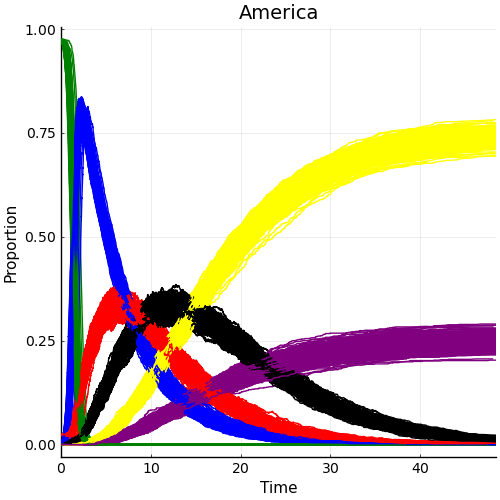

In [249]:
tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
fig1 = Plots.plot(tV,sV/M,label = "Susceptible", c=:green)
Plots.plot!(tV,eV/M,label = "Exposed", c=:blue)
Plots.plot!(tV,iV/M,label = "Infected",c=:red)
Plots.plot!(tV,rV/M,label = "Removed",c=:yellow)
Plots.plot!(tV,hV/M,label = "Hospitalized", c=:black)
Plots.plot!(tV,dV/M,label = "Dead", c=:purple,
    title = "America",
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,tV[end]*1.05))
for i in 1:500
    tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
    Plots.plot!(fig1, tV,sV/M, c=:green, legend = false)
    Plots.plot!(fig1, tV,eV/M, c=:blue)
    Plots.plot!(fig1, tV,iV/M, c=:red)
    Plots.plot!(fig1, tV,rV/M, c=:yellow)
    Plots.plot!(fig1, tV,hV/M, c=:black)
    Plots.plot!(fig1, tV,dV/M, c=:purple)
end
    
fig1

#### 3.2.2.  Chinese epedemic model simulation 

In [250]:
# the values of all parameters

# the rate of transmission for the susceptible to infected 
beta_1 = 0.15801;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.7901;

# the contact rate
r = 10.0;

# the incubation rate
sigma = 1/5.5;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda = 0.09625;

# The mortality rate by covid-19
k = 0.04716;

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

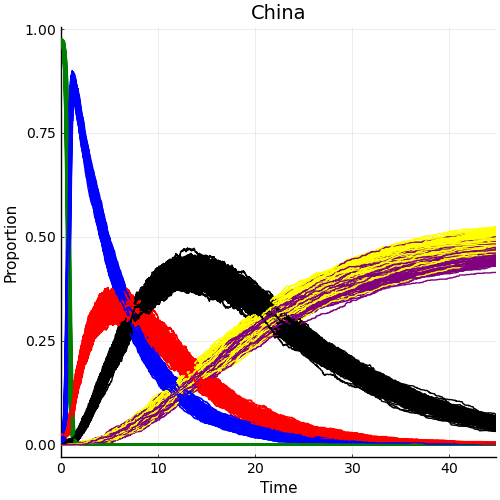

In [251]:
tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
fig2 = Plots.plot(tV,sV/M,label = "Susceptible", c=:green)
Plots.plot!(tV,eV/M,label = "Exposed", c=:blue)
Plots.plot!(tV,iV/M,label = "Infected",c=:red)
Plots.plot!(tV,rV/M,label = "Removed",c=:yellow)
Plots.plot!(tV,hV/M,label = "Hospitalized", c=:black)
Plots.plot!(tV,dV/M,label = "Dead", c=:purple,
    title = "China",
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,tV[end]*1.05))
for i in 1:500
    tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
    Plots.plot!(fig2, tV,sV/M, c=:green, legend = false)
    Plots.plot!(fig2, tV,eV/M, c=:blue)
    Plots.plot!(fig2, tV,iV/M, c=:red)
    Plots.plot!(fig2, tV,rV/M, c=:yellow)
    Plots.plot!(fig2, tV,hV/M, c=:black)
    Plots.plot!(fig2, tV,dV/M, c=:purple)
end
    
fig2

#### 3.2.3.  Australian epedemic model simulation 

In [252]:
# the values of all parameters

# the rate of transmission for the susceptible to infected 
beta_1 = 0.06120;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.30600;

# the contact rate
r = 10.0;

# the incubation rate
sigma = 1/5.5;

# the hospitalization rate 
gamma = 0.22;

# the recovery rate (from hospitalized to recovered)
lambda = 0.09888;

# The mortality rate by covid-19
k = 0.01393;

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

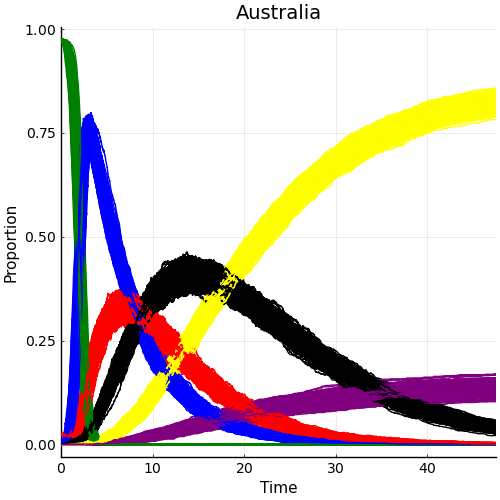

In [255]:
tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
fig3 = Plots.plot(tV,sV/M,label = "Susceptible", c=:green)
Plots.plot!(tV,eV/M,label = "Exposed", c=:blue)
Plots.plot!(tV,iV/M,label = "Infected",c=:red)
Plots.plot!(tV,rV/M,label = "Removed",c=:yellow)
Plots.plot!(tV,hV/M,label = "Hospitalized", c=:black)
Plots.plot!(tV,dV/M,label = "Dead", c=:purple,
    title = "Australia",
    xlabel = "Time", ylabel = "Proportion",
    legend = :topright, xlim = (0,tV[end]*1.05))
for i in 1:500
    tV,sV,eV,iV,rV,hV, dV = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma,lambda,k,Inf,M,I0);
    Plots.plot!(fig3, tV,sV/M, c=:green, legend = false)
    Plots.plot!(fig3, tV,eV/M, c=:blue)
    Plots.plot!(fig3, tV,iV/M, c=:red)
    Plots.plot!(fig3, tV,rV/M, c=:yellow)
    Plots.plot!(fig3, tV,hV/M, c=:black)
    Plots.plot!(fig3, tV,dV/M, c=:purple)
end
    
fig3

## 4. Compartmental Model with CP(convalescent plasma)

Convalescent plasma (CP) has also been used in the COVID-19 pandemic, but limited data can be acquired.
Therefore the aim for this project is to create a compartmental mathematical model for COVID-19 transmission and then apply the control parameter hospitalization to receive medication (immunotherapy and convalescent plasma therapy) and see the effect on recovery from COVID-19 disease. 

###  Model with Different $\gamma$ (hospitalization rate)

In this part, I will apply different $\gamma$ to simulate the impact of different proportions of convalescent serum injection on the epidemic.

In [31]:
# the values of all parameters

# the rate of transmission for the susceptible to infected 
beta_1 = 0.15747;

# the rate of transmission for the susceptible to exposed 
beta_2 = 0.78735;

# the contact rate
r = 3.0;

# the incubation rate
sigma = 1/7;

# the hospitalization rate 
gamma1 = 0.1;
gamma2 = 0.2;
gamma3 = 0.3;
gamma4 = 0.4;
gamma5 = 0.5;

# the recovery rate (from hospitalized to recovered)
lambda = 0.01;

# The mortality rate by covid-19
k = 2.7*10^(-4);

# the inital infected percentage and the total population (S+E+I+H+R+D).
initialInfect, M = 0.025, 1000;

# the inital infected population
I0 = Int(floor(initialInfect*M));

In [35]:
tV_1, sV_1, eV_1, iV_1, rV_1, hV_1, dV_1 = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma1,lambda,k,Inf,M,I0);
tV_2, sV_2, eV_2, iV_2, rV_2, hV_2, dV_2 = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma2,lambda,k,Inf,M,I0);
tV_3, sV_3, eV_3, iV_3, rV_3, hV_3, dV_3 = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma3,lambda,k,Inf,M,I0);
tV_4, sV_4, eV_4, iV_4, rV_4, hV_4, dV_4 = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma4,lambda,k,Inf,M,I0);
tV_5, sV_5, eV_5, iV_5, rV_5, hV_5, dV_5 = moderatedSEIRDoobGillespie(beta_1,beta_2,r,sigma,gamma5,lambda,k,Inf,M,I0);

### Susceptible Comparison

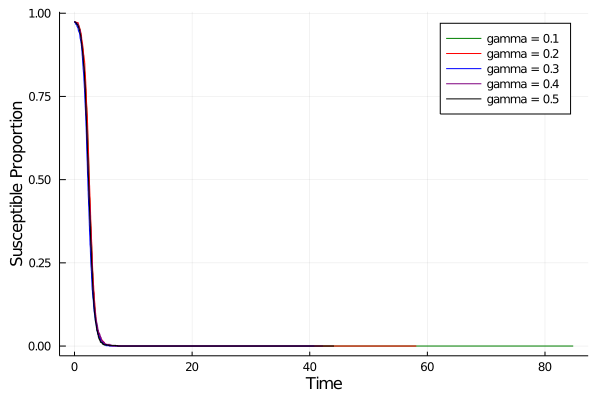

In [45]:
Plots.plot(tV_1,sV_1/M,label = "gamma = 0.1", c=:green)
Plots.plot!(tV_2,sV_2/M,label = "gamma = 0.2", c=:red)
Plots.plot!(tV_3,sV_3/M,label = "gamma = 0.3", c=:blue)
Plots.plot!(tV_4,sV_4/M,label = "gamma = 0.4", c=:purple)
Plots.plot!(tV_5,sV_5/M,label = "gamma = 0.5", c=:black,
            xlabel = "Time", ylabel = "Susceptible Proportion",
            legend = :topright)

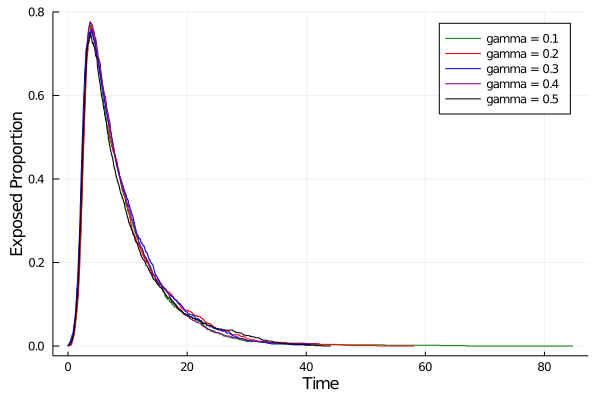

In [47]:
Plots.plot(tV_1,eV_1/M,label = "gamma = 0.1", c=:green)
Plots.plot!(tV_2,eV_2/M,label = "gamma = 0.2", c=:red)
Plots.plot!(tV_3,eV_3/M,label = "gamma = 0.3", c=:blue)
Plots.plot!(tV_4,eV_4/M,label = "gamma = 0.4", c=:purple)
Plots.plot!(tV_5,eV_5/M,label = "gamma = 0.5", c=:black,
            xlabel = "Time", ylabel = "Exposed Proportion",
            legend = :topright)

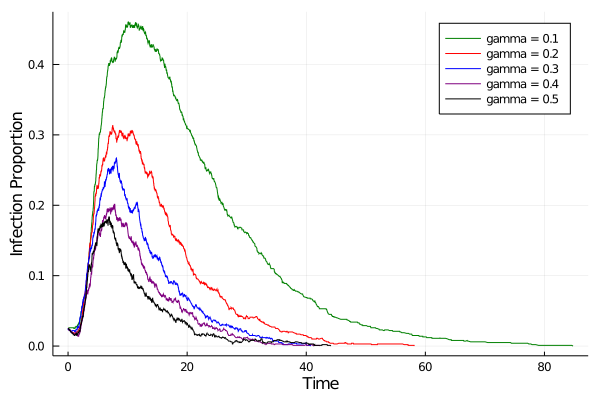

In [44]:
Plots.plot(tV_1,iV_1/M,label = "gamma = 0.1", c=:green)
Plots.plot!(tV_2,iV_2/M,label = "gamma = 0.2", c=:red)
Plots.plot!(tV_3,iV_3/M,label = "gamma = 0.3", c=:blue)
Plots.plot!(tV_4,iV_4/M,label = "gamma = 0.4", c=:purple)
Plots.plot!(tV_5,iV_5/M,label = "gamma = 0.5", c=:black,
            xlabel = "Time", ylabel = "Infection Proportion",
            legend = :topright)

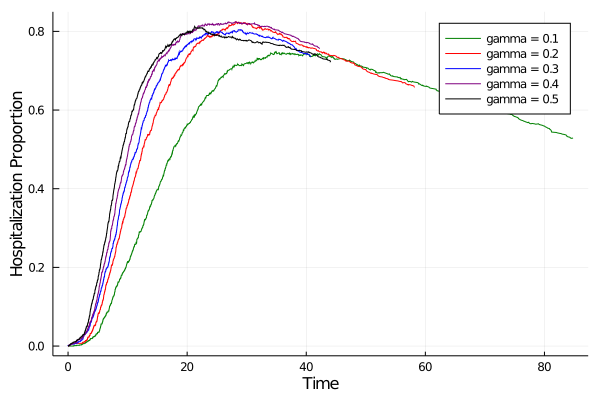

In [48]:
Plots.plot(tV_1,hV_1/M,label = "gamma = 0.1", c=:green)
Plots.plot!(tV_2,hV_2/M,label = "gamma = 0.2", c=:red)
Plots.plot!(tV_3,hV_3/M,label = "gamma = 0.3", c=:blue)
Plots.plot!(tV_4,hV_4/M,label = "gamma = 0.4", c=:purple)
Plots.plot!(tV_5,hV_5/M,label = "gamma = 0.5", c=:black,
            xlabel = "Time", ylabel = "Hospitalization Proportion",
            legend = :topright)

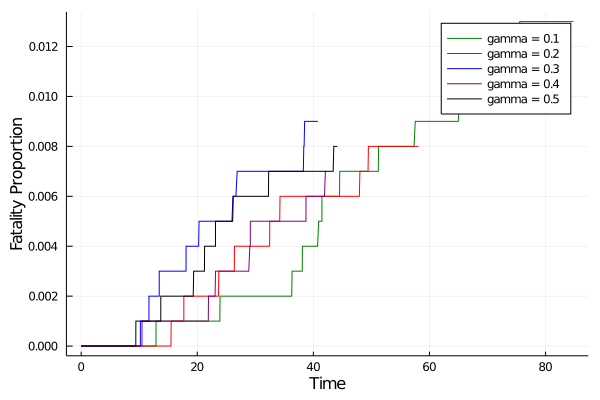

In [49]:
Plots.plot(tV_1,dV_1/M,label = "gamma = 0.1", c=:green)
Plots.plot!(tV_2,dV_2/M,label = "gamma = 0.2", c=:red)
Plots.plot!(tV_3,dV_3/M,label = "gamma = 0.3", c=:blue)
Plots.plot!(tV_4,dV_4/M,label = "gamma = 0.4", c=:purple)
Plots.plot!(tV_5,dV_5/M,label = "gamma = 0.5", c=:black,
            xlabel = "Time", ylabel = "Fatality Proportion",
            legend = :topright)

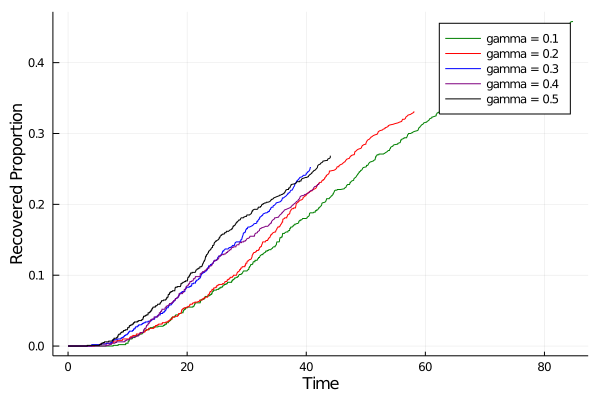

In [50]:
Plots.plot(tV_1,rV_1/M,label = "gamma = 0.1", c=:green)
Plots.plot!(tV_2,rV_2/M,label = "gamma = 0.2", c=:red)
Plots.plot!(tV_3,rV_3/M,label = "gamma = 0.3", c=:blue)
Plots.plot!(tV_4,rV_4/M,label = "gamma = 0.4", c=:purple)
Plots.plot!(tV_5,rV_5/M,label = "gamma = 0.5", c=:black,
            xlabel = "Time", ylabel = "Recovered Proportion",
            legend = :topright)